## Лабораторная работа 5
### Градиентный бустинг с Catboost
### Выполнил: 6133-010302D, Сергунин Станислав Константинович

####  0. Набор данных

Подобрать набор данных для классификации (количество классов не имеет значения) и регрессии. Важно наличие числовых и категориальных признаков в данных. Опишите данные, что обозначает каждый столбец, какого типа (категориальный, вещественный, целочисленный, бинарный) данный столбец, при необходимости для категориальных в том числе бинарных признаков привести расшифровку их значений. 

In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, confusion_matrix



In [6]:
import catboost
from catboost import *
from catboost import datasets
from catboost import CatBoostClassifier

In [7]:
anime = 'anime.csv'
rating = 'rating.csv'
df = pd.read_csv(anime)

In [8]:
df.head(10)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


In [9]:
df = df.drop(columns='name', axis=1)
df = df.drop(columns='genre', axis=1)
df = df.drop(columns='type', axis=1)

In [10]:
df.head(10)

,anime_id,episodes,rating,members
0,32281,1,9.37,200630
1,5114,64,9.26,793665
2,28977,51,9.25,114262
3,9253,24,9.17,673572
4,9969,51,9.16,151266
5,32935,10,9.15,93351
6,11061,148,9.13,425855
7,820,110,9.11,80679
8,15335,1,9.10,72534
9,15417,13,9.11,81109


In [11]:
# преобразуем в целые (чтобы можно было с ними работать, как с категориальными)
df = df.dropna(how='any',axis=0) 
df['rating'] = df['rating'].apply(lambda val: int(val*100))

# работать будем с рейтингом. Поделим на две категории: больше 500 - хороший рейтинг
df['rating'] = df['rating'].apply(lambda val: 1 if val > 500 else 0)
df.head(10)

,anime_id,episodes,rating,members
0,32281,1,1,200630
1,5114,64,1,793665
2,28977,51,1,114262
3,9253,24,1,673572
4,9969,51,1,151266
5,32935,10,1,93351
6,11061,148,1,425855
7,820,110,1,80679
8,15335,1,1,72534
9,15417,13,1,81109


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12064 entries, 0 to 12293
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   anime_id  12064 non-null  int64 
 1   episodes  12064 non-null  object
 2   rating    12064 non-null  int64 
 3   members   12064 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 471.2+ KB


In [13]:
df.describe()

,anime_id,rating,members
count,12064.000000,12064.000000,1.206400e+04
mean,13704.476044,0.911887,1.827952e+04
std,11260.369521,0.283471,5.527578e+04
min,1.000000,0.000000,1.200000e+01
25%,3409.250000,1.000000,2.210000e+02
50%,10004.000000,1.000000,1.539000e+03
75%,23863.500000,1.000000,9.485500e+03
max,34519.000000,1.000000,1.013917e+06


####  1. CatBoostClassifier

Применить классификатор CatBoostClassifier к вашему набору данных. Обратите внимание, что catboost умеет работать с категориальными признаками (параметр cat_features - список индексов категориальных признаков), поэтому использование pd.factorize / pd.get_dummies здесь лишнее.

- Вывести итерацию с наилучшим значением AUC (для бинарной классификации) или наилучшим значением Logloss.
- Вывести значения метрик качества классификации на тестовых данных (accuracy и precision / recall / AUC, если применимо).
- В случае бинарной классификации на основе CatBoostClassifier построить кривые PRC и ROC. Вычислить значения PRC-AUC и ROC-AUC.


In [14]:
# Выделение целевой переменной

Y = df.rating
X = df.drop('rating', axis=1)

In [15]:
# Делим на обучающую и тестовую

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, random_state = 1234)

In [16]:
# Объявление категориальных факторов

cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2]


In [17]:
print('Labels: '.format(set(Y)))
print('Zero count = ' + str(len(Y) - sum(Y)) + ', One count = ' + str(sum(Y)))

Labels: 
Zero count = 1063, One count = 11001


In [18]:
# Обучение модели

model = CatBoostClassifier(
    iterations = 100,
    learning_rate = 0.5,
    random_seed = 63,
    custom_loss = ['AUC', 'Accuracy'],
    logging_level='Info'
)
model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_test, Y_test),
    logging_level='Silent'   
)


In [19]:
# параметры модели
print()
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:' + str(model.get_params()))

# лучшие параметры модели
print()
best_it = model.get_best_iteration()
print('Best iteration: ' + str(best_it))
best_sc = model.best_score_
print('Best score:'  + str(best_sc))


Model is fitted: True
Model params:{'iterations': 100, 'learning_rate': 0.5, 'random_seed': 63, 'logging_level': 'Info', 'custom_loss': ['AUC', 'Accuracy']}

Best iteration: 7
Best score:{'learn': {'Accuracy': 0.9179359651849549, 'Logloss': 0.20514028413772048}, 'validation': {'Accuracy': 0.9079983423124741, 'Logloss': 0.24601980768936166, 'AUC': 0.832114994778549}}


In [20]:
from sklearn.metrics import plot_roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score

In [21]:
# метрики
accur = accuracy_score(Y_test, model.predict(X_test))
roc = roc_auc_score(Y_test, model.predict(X_test))
prec = precision_score(Y_test, model.predict(X_test))
rec = recall_score(Y_test, model.predict(X_test))

In [22]:
print('Accuracy:'  + str(accur))
print('AUC: ' + str(roc))
print('Precision: ' + str(prec))
print('Recall: ' + str(rec))


Accuracy:0.9075839204309988
AUC: 0.5
Precision: 0.9075839204309988
Recall: 1.0


C:\Users\stass\mambaforge\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


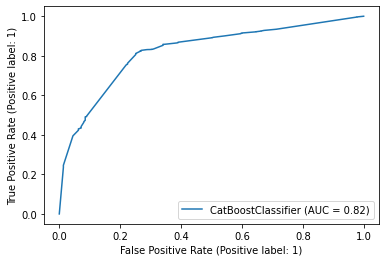

In [23]:
# Roc-кривая
plot_roc_curve(model, X_test, Y_test)

In [24]:
from sklearn.metrics import PrecisionRecallDisplay

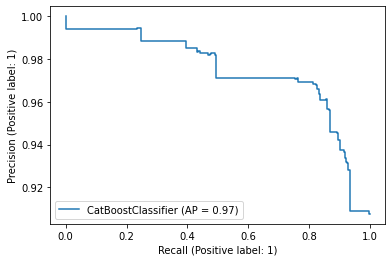

In [25]:
# PRC-кривая и PRC-AUC
PrecisionRecallDisplay.from_estimator(model, X_test, Y_test)

#### 2. Применить регрессию CatBoostRegressor к набору данных для регрессии. 

Вывести номер итерации и значения метрик (MAE и MSE) для наилучшей итерации. Обратите внимание, что в задаче восстановления регрессии целевая переменная имеет непрерывные значения.

In [47]:
model1 = CatBoostRegressor(
    custom_metric=["MAE", "RMSE"], 
    cat_features = cat_features
)

model1.fit(
    X_train, Y_train,
    eval_set=(X_test, Y_test),
    logging_level='Silent'
)

In [48]:
# лучшие параметры модели
print()
best_it = model1.get_best_iteration()
print('Best iteration: ' + str(best_it))
best_sc = model1.best_score_
print('Best score:'  + str(best_sc))


Best iteration: 106
Best score:{'learn': {'MAE': 0.1140179540123535, 'RMSE': 0.22917876312622182}, 'validation': {'MAE': 0.12992201944970755, 'RMSE': 0.2616299359060073}}


In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [50]:
# метрики качества регрессии
mae1 = mean_absolute_error(Y_test, model1.predict(X_test))
print('MAE: ', mae1)
mse1 = mean_squared_error(Y_test, model1.predict(X_test))
print('MSE: ', mse1)

MAE:  0.13192310552238345
MSE:  0.06845022336218122
